In [1]:
import pandas as pd
import numpy
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

plt.rc('axes', axisbelow=True)
import matplotlib

font = {
        'family' : 'serif',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

In [3]:
vd = 3
ds = 1
file_folder = f"/home/cadams/CosmicTagger/vertexID-ana-files-Jan22/uresnet2-vd{vd}-ds{ds}/"
file_format = "rank_{rank}_uresnet2-vd{vd}-ds1.csv"

dfs = []
for rank in range(8):
    df = pd.read_csv(file_folder + file_format.format(rank=rank, vd=vd))
    dfs.append(df)
    


In [4]:
# print(df.iloc[0:20])

In [5]:
df = pd.concat(dfs)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44928 entries, 0 to 5615
Data columns (total 54 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                44928 non-null  int64  
 1   index                     44928 non-null  int64  
 2   event_id                  44928 non-null  object 
 3   energy                    44928 non-null  float64
 4   predicted_vertex0h        44928 non-null  float64
 5   predicted_vertex0w        44928 non-null  float64
 6   predicted_vertex1h        44928 non-null  float64
 7   predicted_vertex1w        44928 non-null  float64
 8   predicted_vertex2h        44928 non-null  float64
 9   predicted_vertex2w        44928 non-null  float64
 10  true_vertex0h             44928 non-null  float64
 11  true_vertex0w             44928 non-null  float64
 12  true_vertex1h             44928 non-null  float64
 13  true_vertex1w             44928 non-null  float64
 14  true_ve

In [7]:
# Add some derived metrics:
for plane in range(3):
    df[f"h_res_{plane}"]  = (df[f"predicted_vertex{plane}h"] - df[f"true_vertex{plane}h"])**2
    df[f"w_res_{plane}"]  = (df[f"predicted_vertex{plane}w"] - df[f"true_vertex{plane}w"])**2
    df[f"h_diff_{plane}"] = df[f"predicted_vertex{plane}h"] - df[f"true_vertex{plane}h"]
    df[f"w_diff_{plane}"] = df[f"predicted_vertex{plane}w"] - df[f"true_vertex{plane}w"]
    df[f"vertex_res{plane}"] = (df[f"h_res_{plane}"] + df[f"w_res_{plane}"])**0.5

In [8]:
def plot_energy(_df, title=None):
    # Split the dataframe by true neutrino type:
    df_nue = _df.query("true_label == 0")
    df_numu = _df.query("true_label == 1")
    df_NC = _df.query("true_label == 2")
    df_cosmic = _df.query("true_label == 3")

    # Plot a histogram of the energy for each type of particle:

    e_bins = numpy.arange(0,10.0, 0.1)

    fig = plt.figure(figsize=(16,9))

    nue_hist,  bin_edges = numpy.histogram(df_nue["energy"],  bins=e_bins)
    numu_hist, bin_edges = numpy.histogram(df_numu["energy"], bins=e_bins)
    NC_hist,   bin_edges = numpy.histogram(df_NC["energy"],   bins=e_bins)
    c_hist,    bin_edges = numpy.histogram(df_cosmic["energy"],   bins=e_bins)

    bin_centers = 0.5*(bin_edges[1:] + bin_edges[0:-1])

    plt.plot(bin_centers, nue_hist,  label=r"$\nu_e$ CC (N={})".format(numpy.sum(nue_hist)))
    plt.plot(bin_centers, numu_hist, label=r"$\nu_\mu$ CC (N={})".format(numpy.sum(numu_hist)))
    plt.plot(bin_centers, NC_hist,   label=r"NC (N={})".format(numpy.sum(NC_hist)))
    plt.plot(bin_centers, c_hist,    label=r"Cosmics (N={})".format(numpy.sum(c_hist)))

    if title is not None:
        plt.title(title)
    
    plt.legend()
    plt.grid(True)

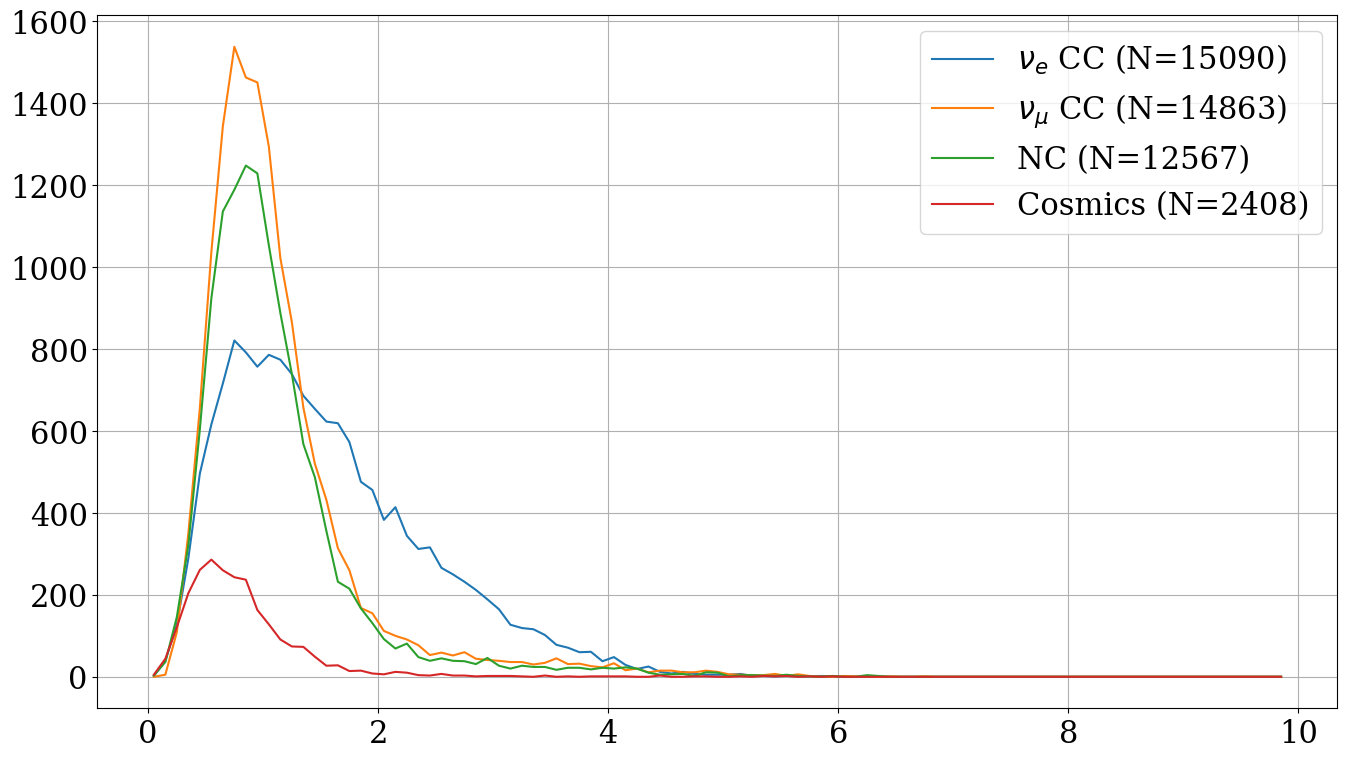

In [9]:
plot_energy(df)

In [10]:
def plot_confusion_matrix(_df, title=None):
    #Plot the confusion matrix of event ID:
    n_tot = len(_df)
    print(n_tot)
    conf_matrix = []
    for i in range(4):
        conf_matrix.append([])
        df_true = _df.query(f"true_label == {i}")
        for j in range(4):
            df_selected = df_true.query(f"predicted_label == {j}")
            fraction = len(df_selected) / len(df_true)
            conf_matrix[i].append(fraction)
    conf_matrix = numpy.asarray(conf_matrix)
    print(conf_matrix)

    labels=[r"$\nu_e$ CC", r"$\nu_\mu$ CC", r"NC", r"Cosmic"]

    fig = plt.figure(figsize=(12,12))
    plt.gca().matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    plt.xlabel("Prediction")
    plt.ylabel("True Label")
    plt.xticks(ticks=range(4), labels=labels)
    plt.yticks(ticks=range(4), labels=labels)
    for i in range(4):
        for j in range(4):
            plt.gca().text(x=j, y=i, s=f"{100*conf_matrix[i,j]:.1f}%", va="center", ha="center")

            
    if title is not None:
        plt.title(title)

44928
[[0.87236581 0.06235918 0.06388337 0.00139165]
 [0.07777703 0.82331965 0.09372267 0.00518065]
 [0.11538155 0.10909525 0.73159863 0.04392456]
 [0.0070598  0.02325581 0.42857143 0.54111296]]


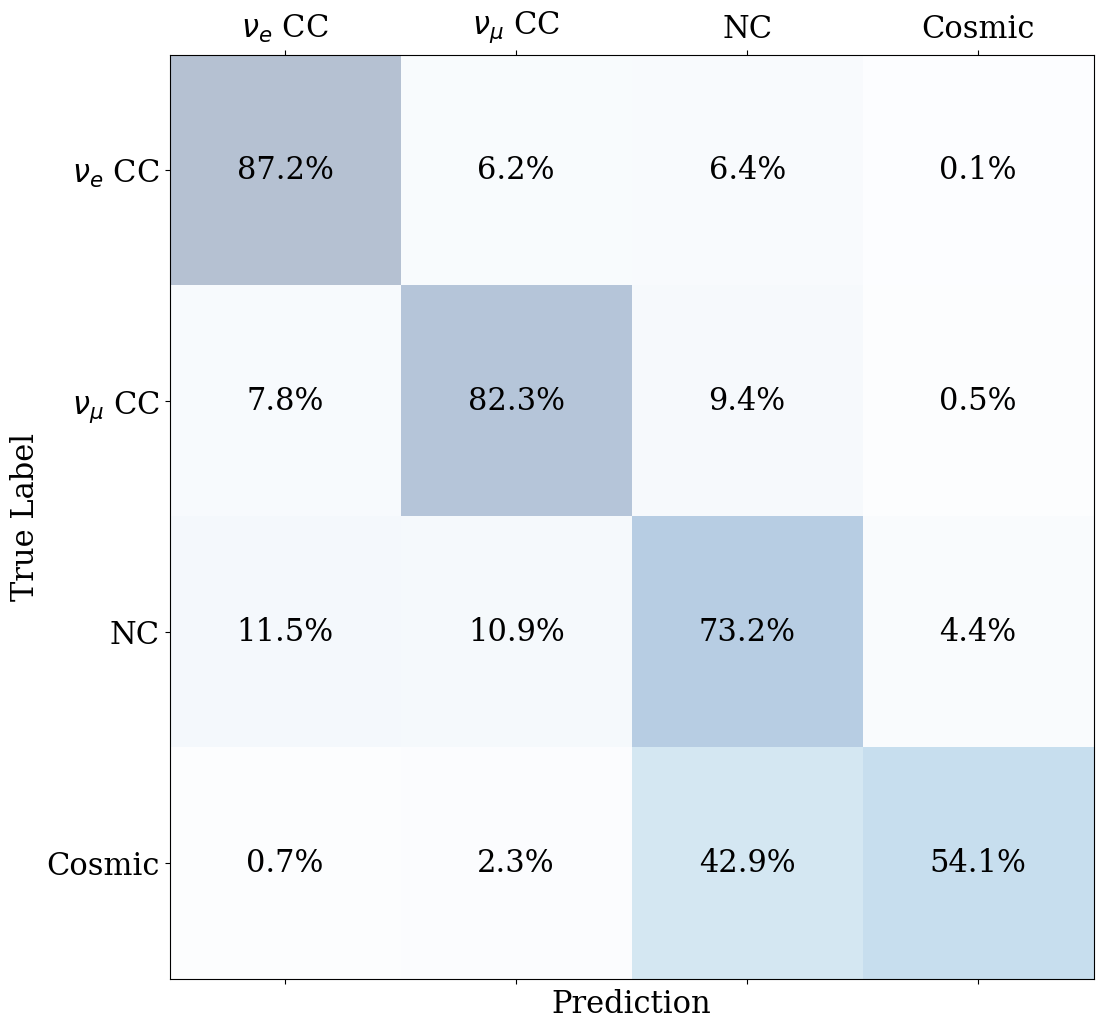

In [11]:
plot_confusion_matrix(df)

In [12]:
# df["prediction_label"]

In [13]:

def compute_key_plot(_df, min_bins, max_bins, key):
    energy = []
    vals   = []
    for min_b, max_b in zip(min_bins, max_bins):
        sub_df = _df.query(f"energy >= {min_b} & energy < {max_b}")
        energy.append(0.5*(min_b + max_b))
        vals.append(sub_df[key].mean())
    return energy, vals

In [14]:
bin_size=0.1
min_e_bin = numpy.arange(0,3.0, bin_size)
max_e_bin = min_e_bin + bin_size
print(min_e_bin)
print(max_e_bin)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9]
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3. ]


In [15]:

def plot_iou(_df, title=None):
    # Plot the IoU metrics as a function of energy:
    fig = plt.figure(figsize=(16,9))

    df_nue = _df.query("true_label==0")
    df_numu = _df.query("true_label==1")
    df_NC = _df.query("true_label==2")

    labels=[r"$\nu_e$ CC", r"$\nu_\mu$ CC", r"NC", r"Cosmic"]

    
    nue_e, nue_c_iou = compute_key_plot(df_nue, min_e_bin, max_e_bin, "Average/Cosmic_IoU")
    numu_e, numu_c_iou = compute_key_plot(df_numu, min_e_bin, max_e_bin, "Average/Cosmic_IoU")
    nc_e, nc_c_iou = compute_key_plot(df_NC, min_e_bin, max_e_bin, "Average/Cosmic_IoU")

    nue_e, nue_n_iou = compute_key_plot(df_nue, min_e_bin, max_e_bin, "Average/Neutrino_IoU")
    numu_e, numu_n_iou = compute_key_plot(df_numu, min_e_bin, max_e_bin, "Average/Neutrino_IoU")
    nc_e, nc_n_iou = compute_key_plot(df_NC, min_e_bin, max_e_bin, "Average/Neutrino_IoU")


    l1, = plt.plot(nue_e, nue_c_iou, label=labels[0], color="blue") 
    l2, = plt.plot(numu_e, numu_c_iou, label=labels[1], color="black") 
    l3, = plt.plot(nc_e, nc_c_iou, label=labels[2], color="green") 

    l4, = plt.plot(nue_e, nue_n_iou, color="blue", ls="--", label="Neutrino") 
    plt.plot(numu_e, numu_n_iou, color="black", ls="--") 
    plt.plot(nc_e, nc_n_iou, color="green", ls="--") 

    legend1 = plt.legend(handles=[l1, l2, l3], loc="lower right")
    plt.gca().add_artist(legend1)
    legend2 = plt.legend(handles=[l1, l4], labels=["Cosmic", "Neutrino"], loc="lower left")

    plt.xlabel("Energy")
    plt.ylabel("Intersection / Union")
    # plt.legend()

    # plt.legend(["blue", "orange"], loc=0)
    # legend = plt.legend([l1, l2], ["Neutrino", "Cosmic"], loc=3, fontsize=20)
    # plt.gca().add_artist(legend)
    if title is not None:
        plt.title(title)
    plt.grid(True)
    plt.ylim([0,1])
    plt.show()

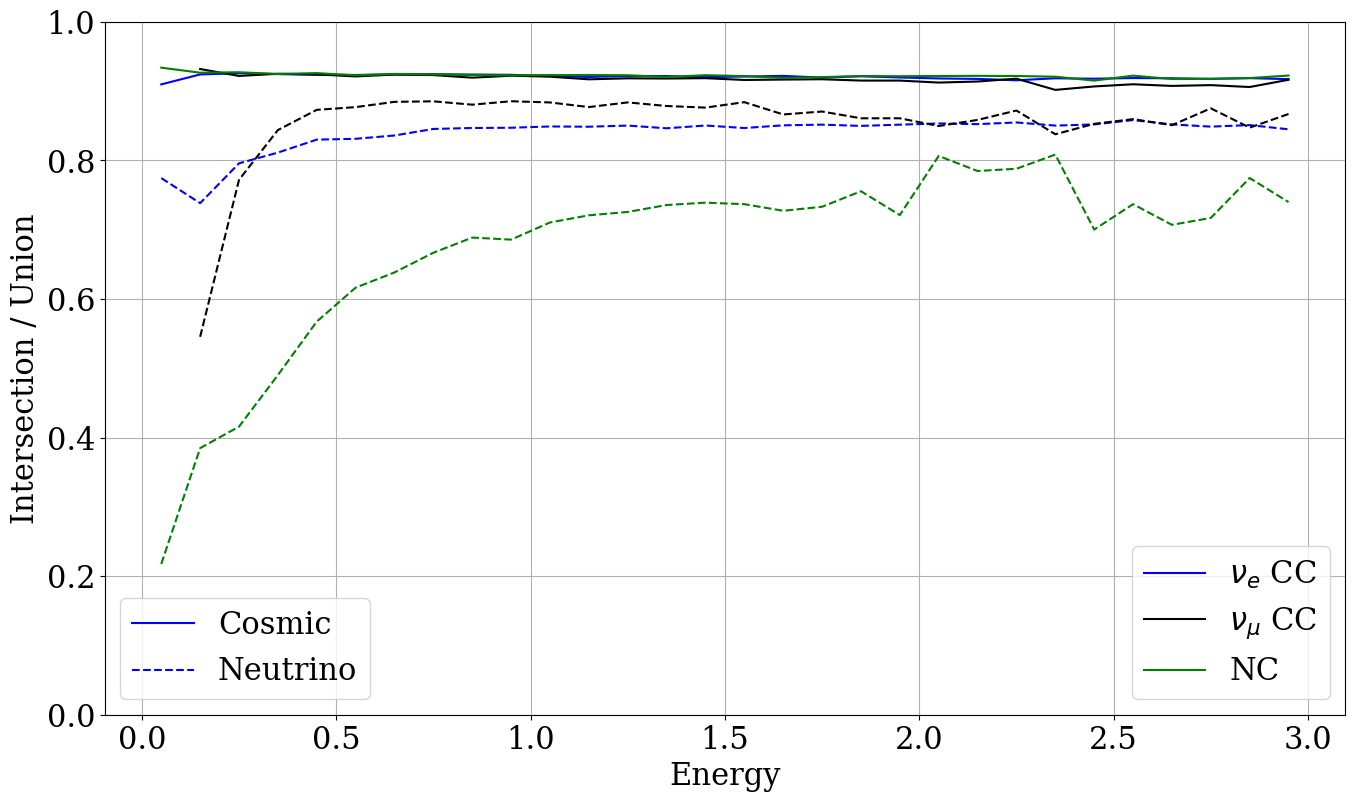

In [16]:
plot_iou(df)

In [20]:
def plot_vertex_offset_grid(_df, bins, cut_line = None, title=None):
    
    colors = ["orange", "red", "green"]
    
    fig, axs = plt.subplots(2,3, figsize=(16,9))
    if title is not None:
        fig.suptitle(title)
        
    plt.subplots_adjust(wspace=0, hspace=0)
    for i_d, d in enumerate(["h","w"]):
        for i_p, p in enumerate(range(3)):
            
            plt.sca(axs[i_d, i_p])
            
            if cut_line is not None:
                selected = _df.query(f"{d}_diff_{p} < {cut_line} & {d}_diff_{p}> -{cut_line}")
                eff = len(selected) / len(_df)
#                 print(eff)
                
            # Get the difference for this _df:
            vals, bin_edges = numpy.histogram(_df[f"{d}_diff_{p}"], bins)
            vals = vals / numpy.sum(vals)
            
            bin_centers = 0.5*(bin_edges[1:] + bin_edges[0:-1])
            bin_widths  = bin_edges[1:] - bin_edges[0:-1]
            if d == "h":
                label = r"Plane {p}, $\Delta$ y".format(p=p)
            else:
                label = r"Plane {p}, $\Delta$ x".format(p=p)
            
            y_max = 0.5
            y_min = 0.00
        
            bar = plt.bar(bin_centers, vals, width = bin_widths, color=colors[i_p], alpha=1.0, zorder=40)
            if cut_line is not None:
                plt.axvline(cut_line, ls="--", color="black")
                plt.axvline(-cut_line, ls="--", color="black")
                plt.text( cut_line*1.05, 0.6*y_max, f"{100*eff:.1f}%")
                
            if i_p == 0:
                plt.ylabel("Distribution [%]")
            else:
                plt.tick_params(left = False, right = False , labelleft = False)
                
            if i_d == 0:
                plt.tick_params(labelbottom = False, bottom = False)
            else:
                plt.xlabel("Offset [cm]")

            
            plt.ylim(y_min,y_max)
#             plt.yscale("log")
#             plt.xscale("log")
            plt.legend(handles = [bar,], labels=[label,])
            
            # Don't allow the axis to be on top of your data
            plt.gca().set_axisbelow(True)

            # Turn on the minor TICKS, which are required for the minor GRID
            axs[i_d, i_p].minorticks_on()
            axs[i_d, i_p].grid(which='major', linestyle='-', linewidth='0.5', color='red',zorder=0)
            # Customize the minor grid
            axs[i_d, i_p].grid(which='minor', linestyle=':', linewidth='0.5', color='black',zorder=0)

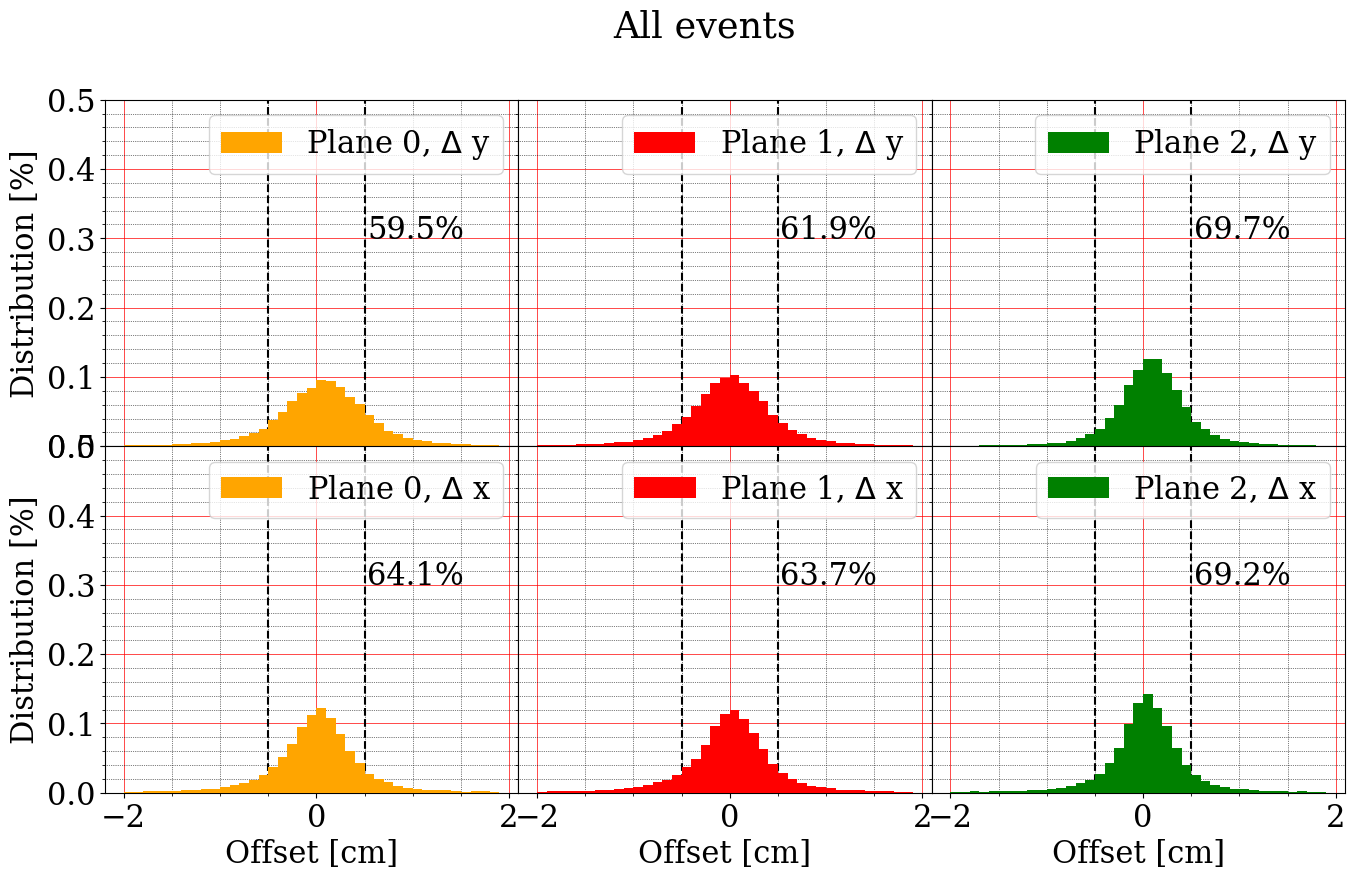

In [21]:
bins = numpy.arange(-2,2,0.1)
plot_vertex_offset_grid(df, bins, cut_line=0.5, title=r"All events")
# plot_vertex_offset_grid(df_nue, bins, cut_line=0.5, title=r"$\nu_e$ CC - all events")
# plot_vertex_offset_grid(df_numu, bins, cut_line=0.5, title=r"$\nu_\mu$ CC - all events")
# plot_vertex_offset_grid(df_NC, bins, cut_line=0.5, title=r"NC - all events")

Text(0.5, 0, 'Z Position, True [cm]')

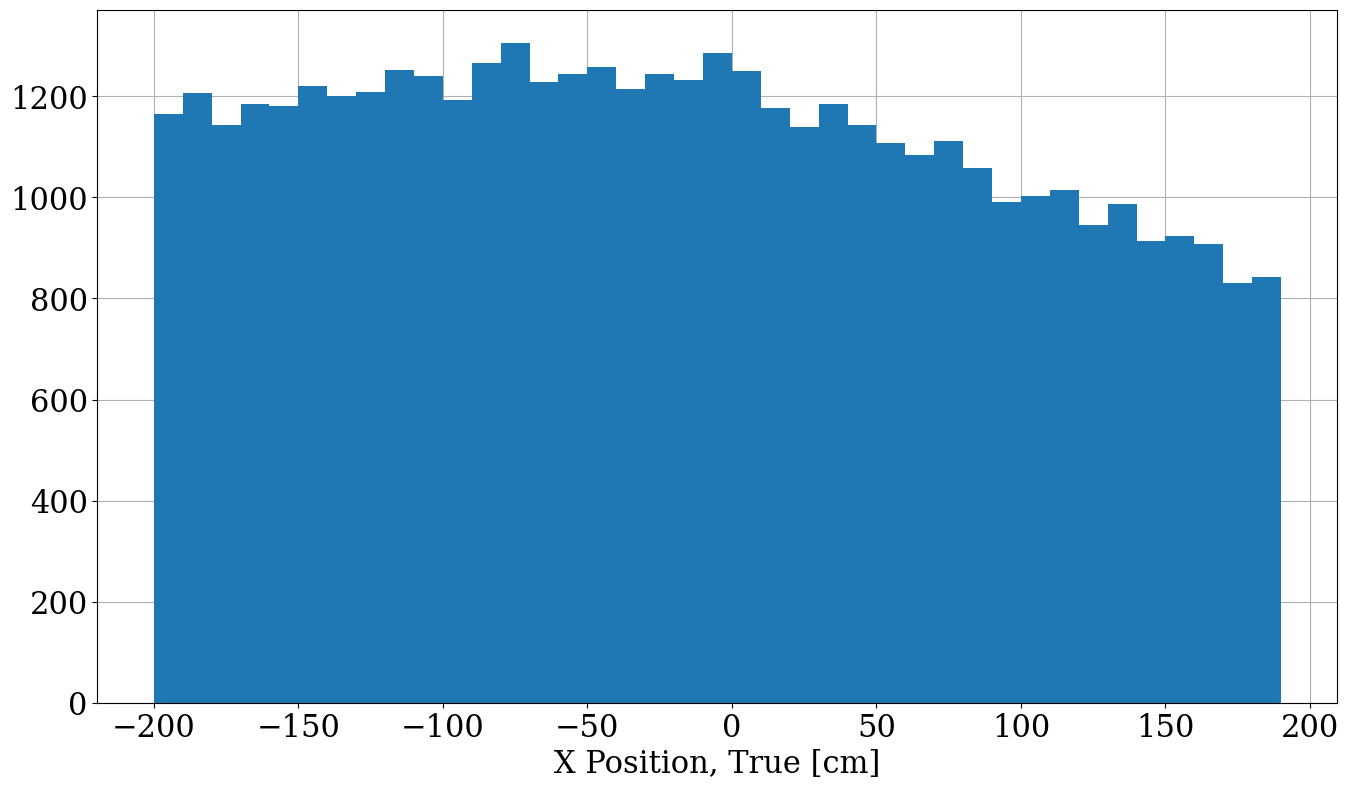

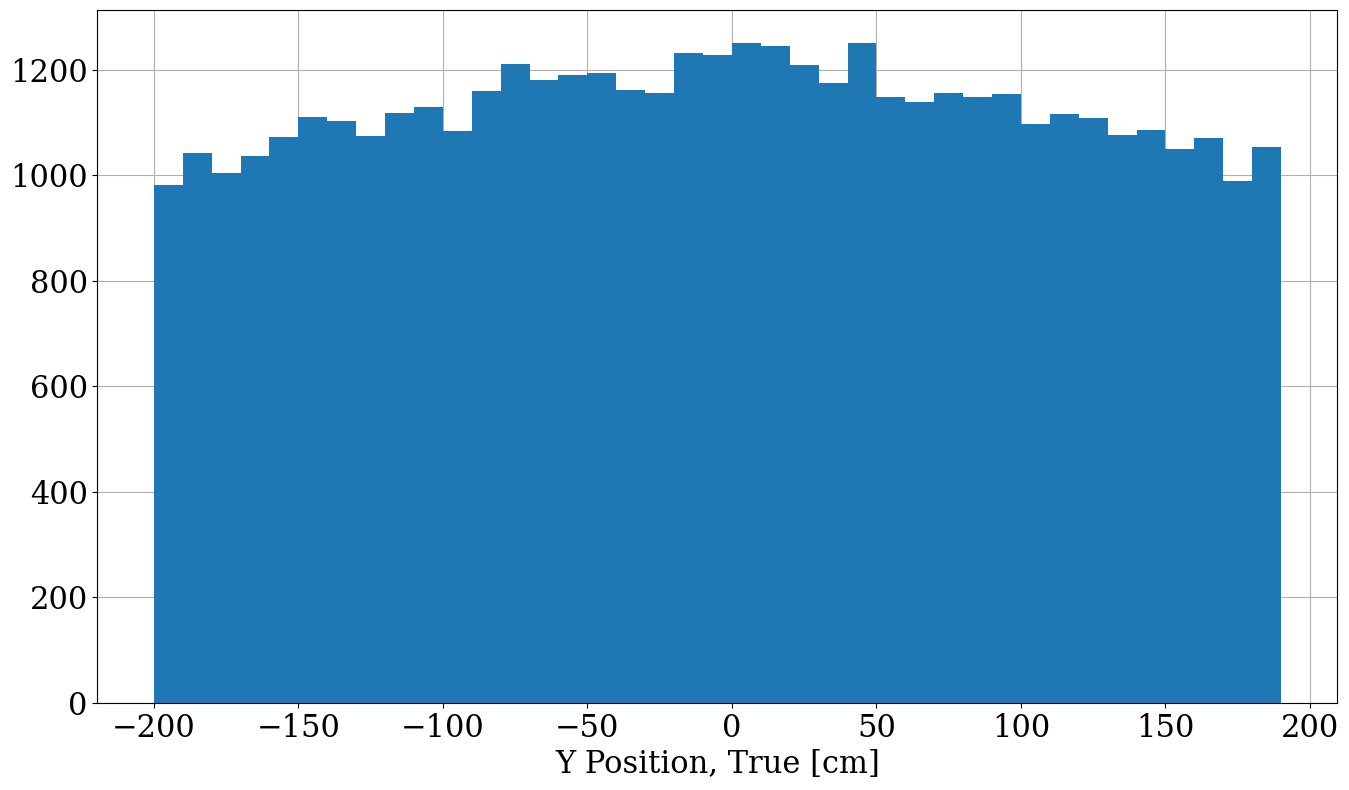

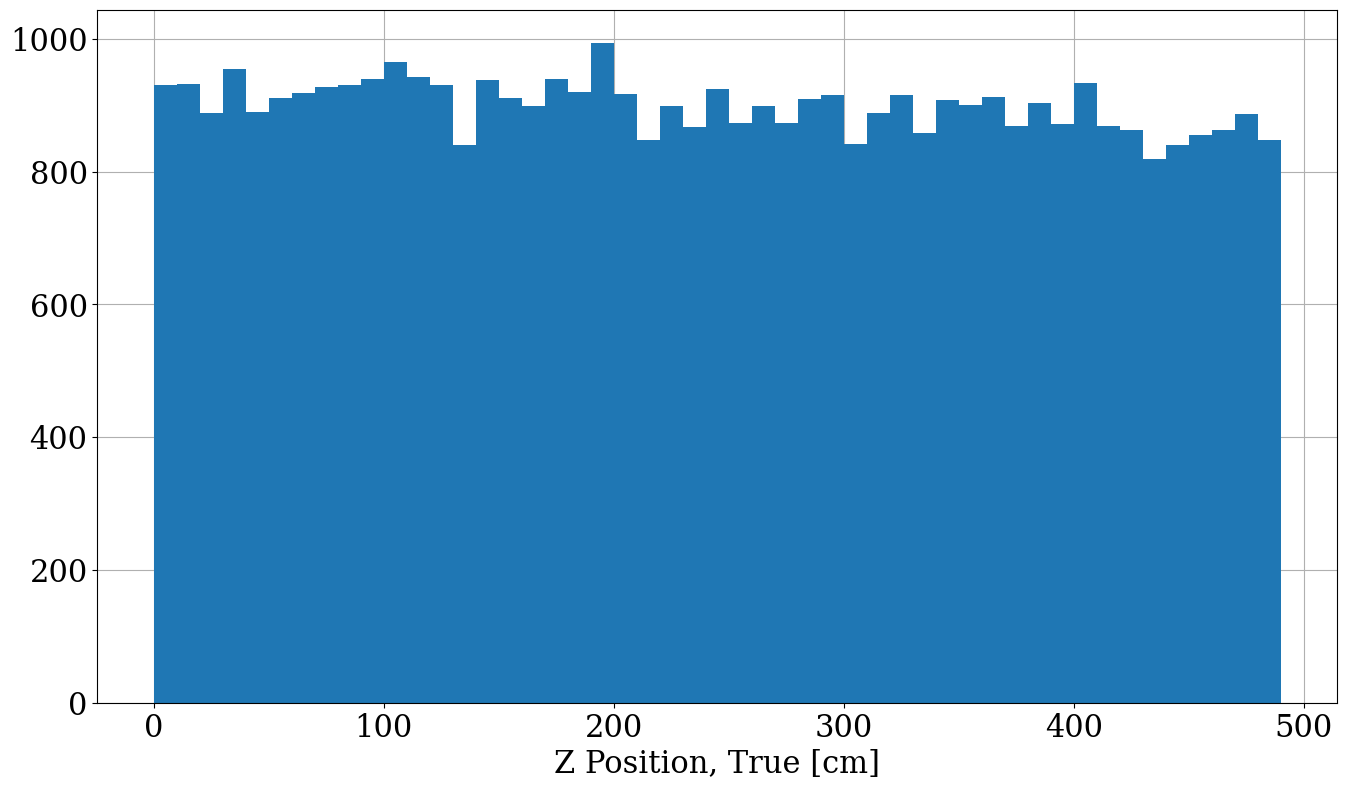

In [22]:
# This is a fiducial volume cut:
fig = plt.figure(figsize=(16,9))
bins = numpy.arange(-200,200,10)
df["vertex_3dx"].hist(bins=bins)
plt.xlabel("X Position, True [cm]")

fig = plt.figure(figsize=(16,9))
df["vertex_3dy"].hist(bins=bins)
plt.xlabel("Y Position, True [cm]")

fig = plt.figure(figsize=(16,9))
bins = numpy.arange(-0,500,10)
df["vertex_3dz"].hist(bins=bins)
plt.xlabel("Z Position, True [cm]")

In [23]:
# Construct an mctruth cut:
df['fiducial_x'] = numpy.abs(df['vertex_3dx']) < 180
df['fiducial_y'] = numpy.abs(df['vertex_3dy']) < 180
df['fiducial_z'] = df['vertex_3dz'].between(50, 450)
df['fiducial'] = (df["fiducial_x"] & df["fiducial_y"] & df["fiducial_z"])


In [24]:
# Construct reconstruction cuts:
cross_plane_vertex_gap_max = 1.5
n_neutrino_pixels_min = 10
df['v_select0'] = numpy.abs(df['predicted_vertex0h'] - df['predicted_vertex1h']) < cross_plane_vertex_gap_max
df['v_select1'] = numpy.abs(df['predicted_vertex0h'] - df['predicted_vertex2h']) < cross_plane_vertex_gap_max
df['v_select2'] = numpy.abs(df['predicted_vertex2h'] - df['predicted_vertex1h']) < cross_plane_vertex_gap_max
df['v_select'] = (df['v_select0'] & df['v_select1'] & df['v_select2'])

df['n_select0'] =  df["N_neut_pixels0"] > n_neutrino_pixels_min
df['n_select1'] =  df["N_neut_pixels1"] > n_neutrino_pixels_min
df['n_select2'] =  df["N_neut_pixels2"] > n_neutrino_pixels_min

df['n_select'] = (df['n_select0'] & df['n_select1'] & df['n_select2'])

df['select'] = df['n_select'] & df['v_select']


In [25]:

df_fiducial = df.query("fiducial")
print(f"{100*len(df_fiducial) / len(df):.1f}")

66.4


29838
[[8.96381910e-01 4.08040201e-02 6.24120603e-02 4.02010050e-04]
 [6.90835851e-02 8.38368580e-01 8.88217523e-02 3.72608258e-03]
 [1.11059044e-01 9.82895970e-02 7.50702905e-01 3.99484536e-02]
 [4.92264416e-03 2.39099859e-02 4.36708861e-01 5.34458509e-01]]


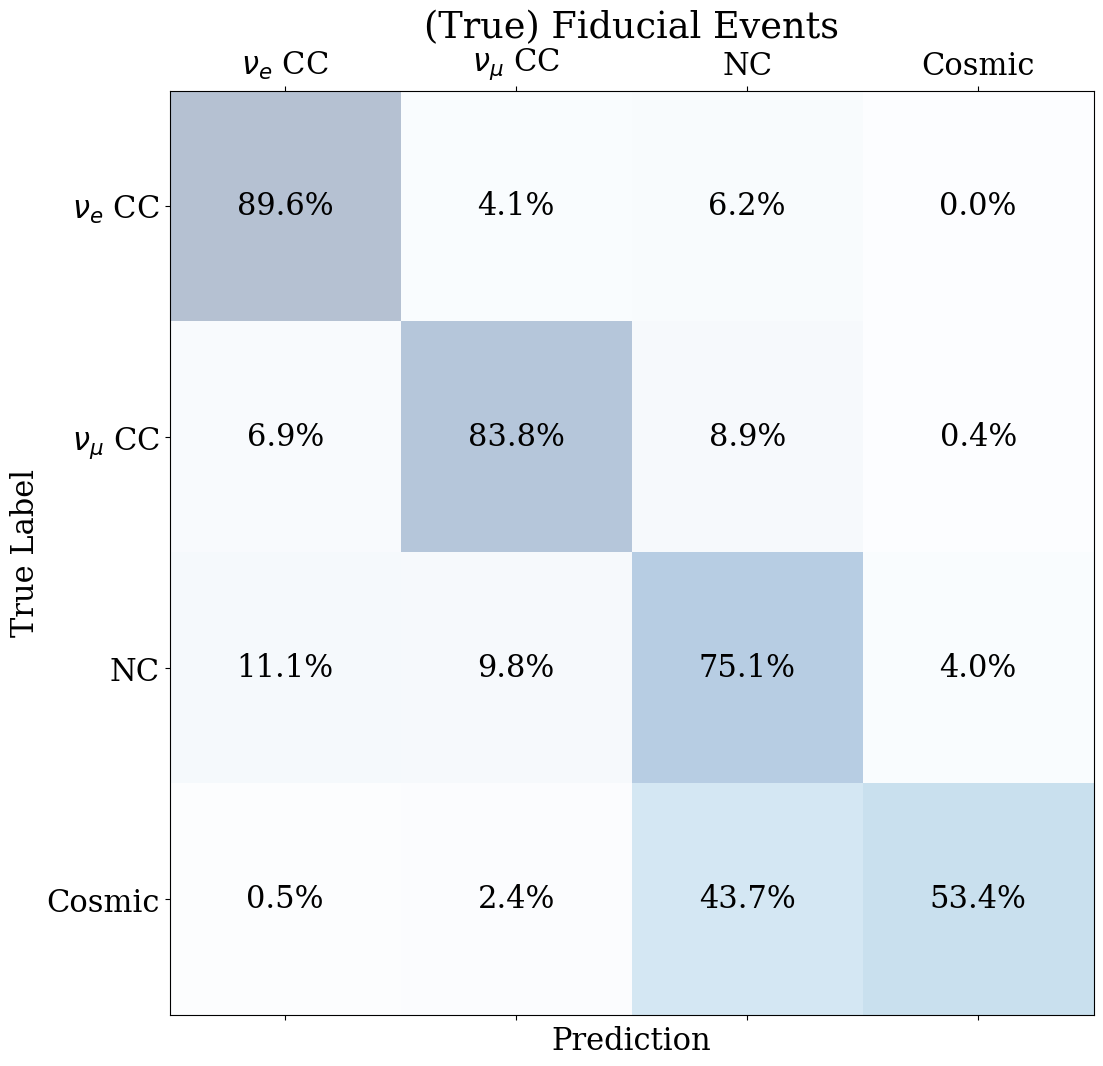

In [26]:
plot_confusion_matrix(df_fiducial, title="(True) Fiducial Events")

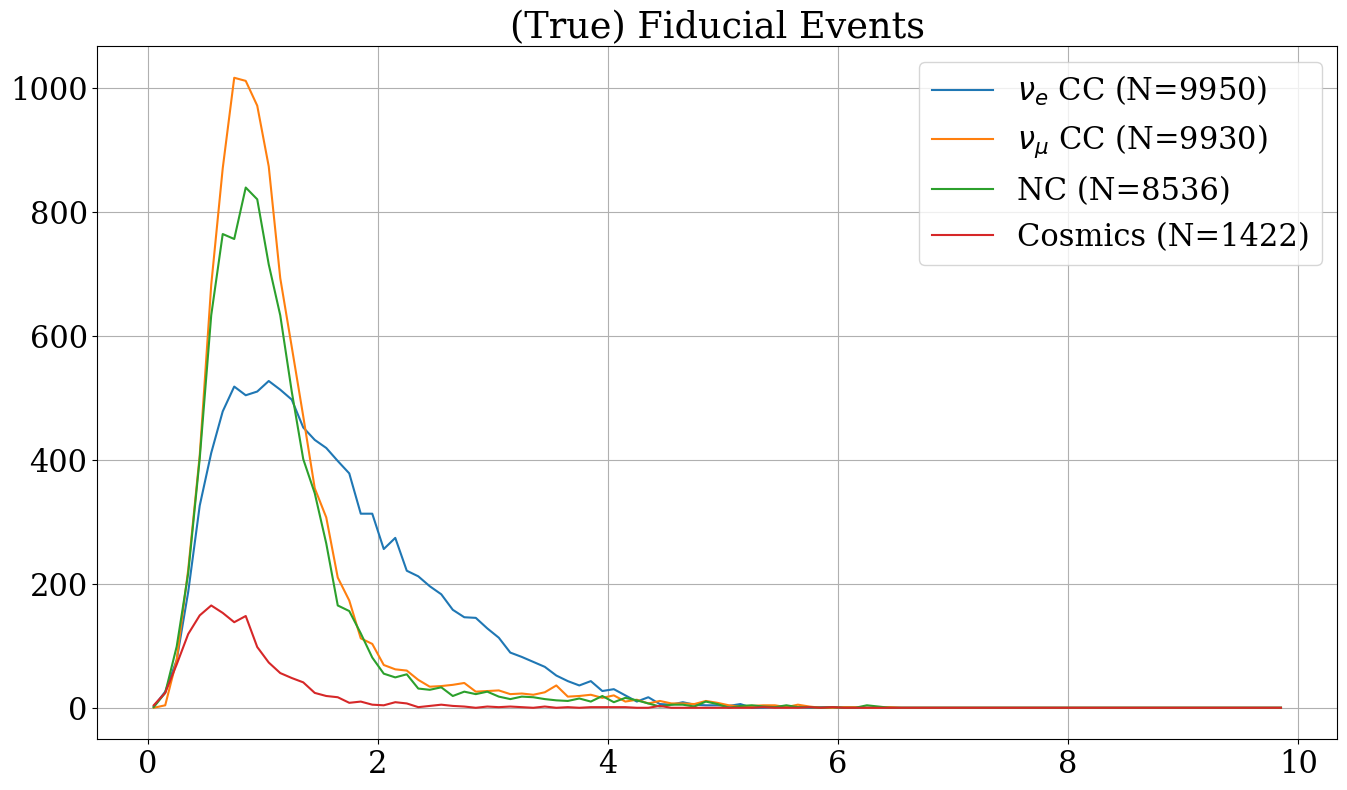

In [27]:
plot_energy(df_fiducial, title="(True) Fiducial Events")

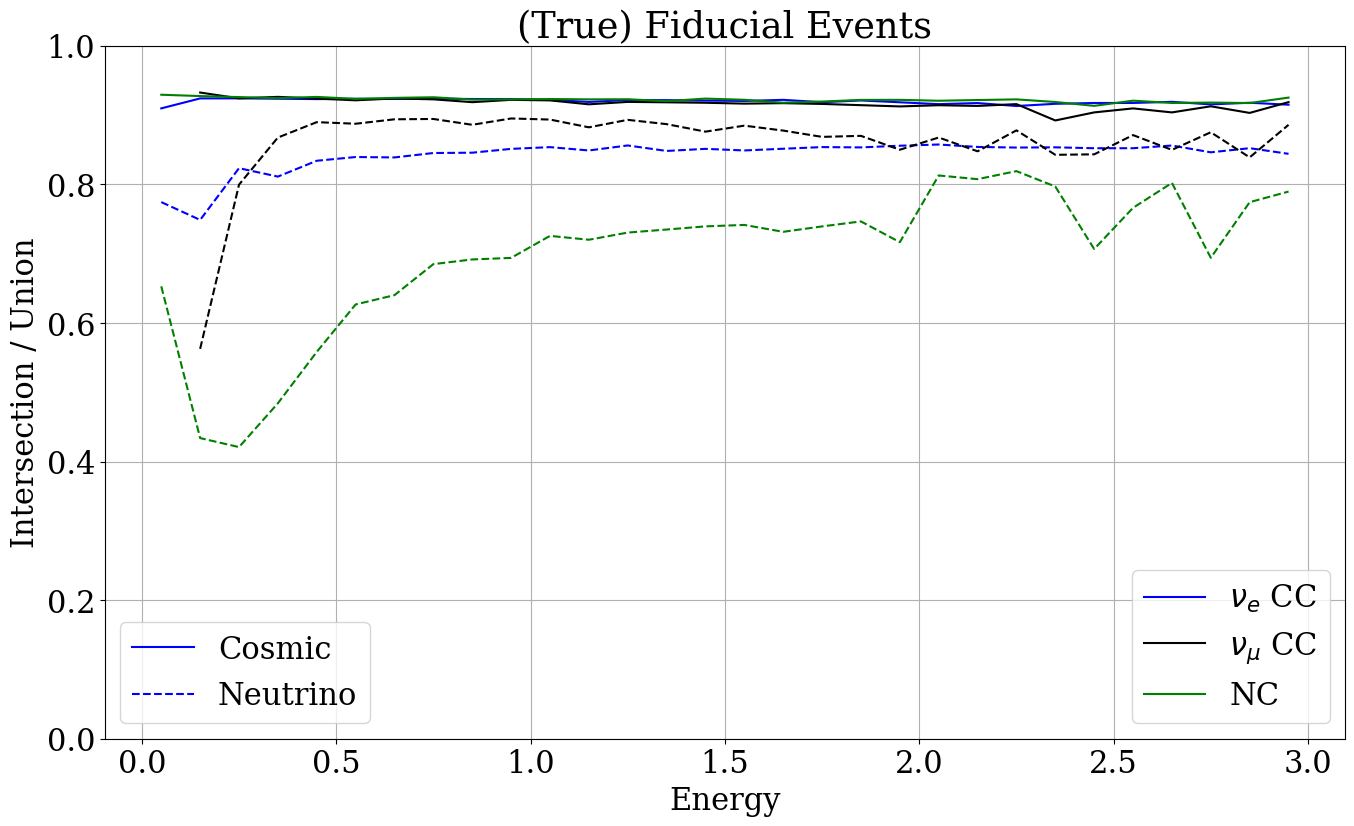

In [28]:
plot_iou(df_fiducial, title="(True) Fiducial Events")

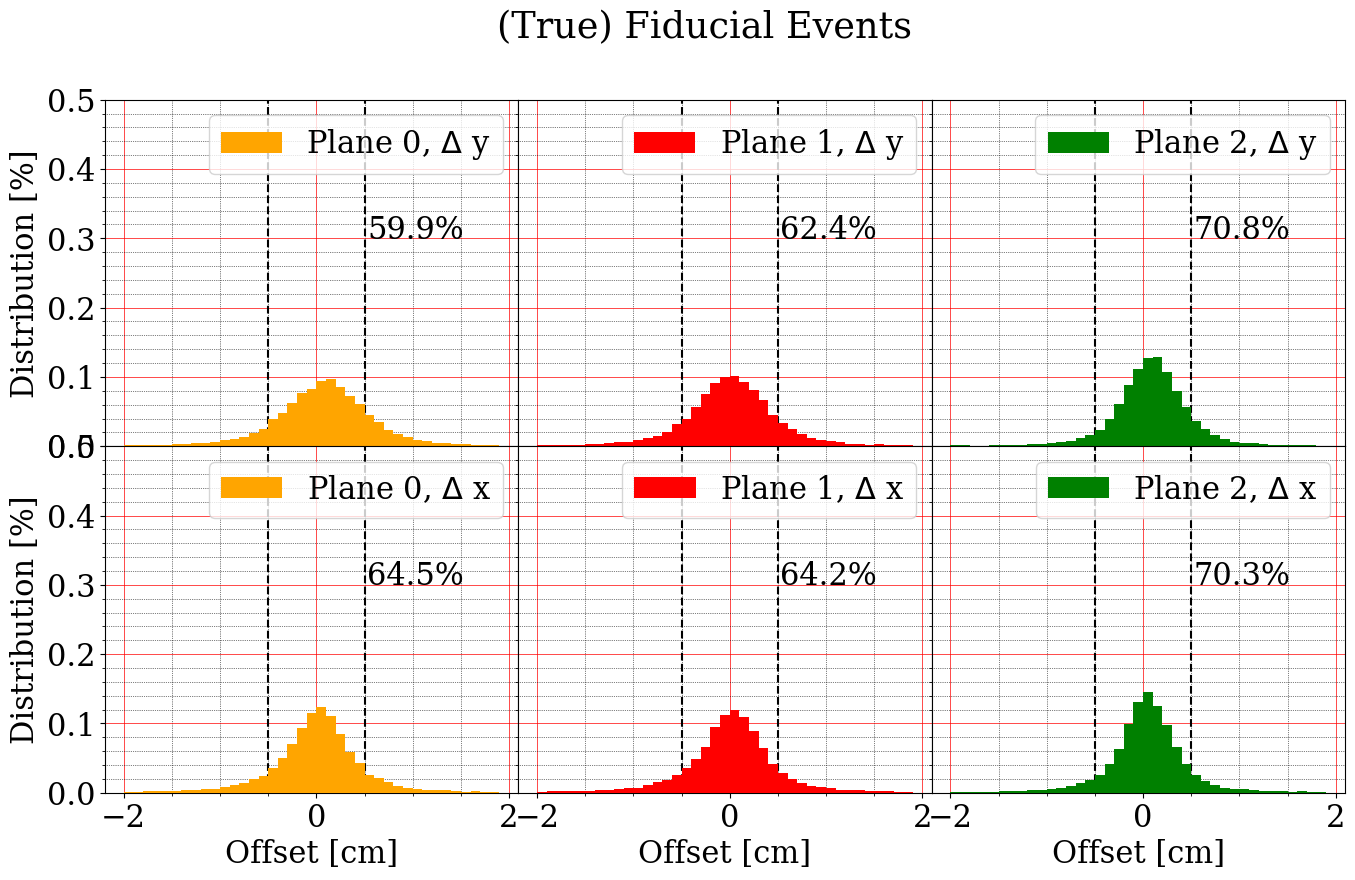

In [29]:
bins = numpy.arange(-2,2,0.1)
plot_vertex_offset_grid(df_fiducial, bins=bins, cut_line=0.5, title="(True) Fiducial Events")

In [30]:
df_selected = df.query('select')

In [31]:
def print_selection_stats(_df, key):
    df_selected = _df.query(key)
    print("Total starting events: ", len(_df))
    print("  Total selected events: ", len(df_selected), f"{100*len(df_selected) / len(_df):.1f}%")

In [32]:
df_neut = df.query('true_label != 3')
print_selection_stats(df_neut, "n_select")
print_selection_stats(df_neut, "v_select")
print_selection_stats(df_neut, "select")

df_neut = df_fiducial.query('true_label != 3')
print_selection_stats(df_neut, "n_select")
print_selection_stats(df_neut, "v_select")
print_selection_stats(df_neut, "select")

Total starting events:  42520
  Total selected events:  38117 89.6%
Total starting events:  42520
  Total selected events:  32099 75.5%
Total starting events:  42520
  Total selected events:  29613 69.6%
Total starting events:  28416
  Total selected events:  25662 90.3%
Total starting events:  28416
  Total selected events:  21667 76.2%
Total starting events:  28416
  Total selected events:  20072 70.6%


In [33]:
df_cosmic = df.query('true_label == 3')
print_selection_stats(df_cosmic, "n_select")
print_selection_stats(df_cosmic, "v_select")
print_selection_stats(df_cosmic, "select")


Total starting events:  2408
  Total selected events:  119 4.9%
Total starting events:  2408
  Total selected events:  487 20.2%
Total starting events:  2408
  Total selected events:  48 2.0%


In [34]:
df_nue = df.query('true_label == 0')
print_selection_stats(df_nue, "n_select")
print_selection_stats(df_nue, "v_select")
print_selection_stats(df_nue, "select")

df_nue = df_fiducial.query('true_label == 0')
print_selection_stats(df_nue, "n_select")
print_selection_stats(df_nue, "v_select")
print_selection_stats(df_nue, "select")

Total starting events:  15090
  Total selected events:  14975 99.2%
Total starting events:  15090
  Total selected events:  12527 83.0%
Total starting events:  15090
  Total selected events:  12479 82.7%
Total starting events:  9950
  Total selected events:  9921 99.7%
Total starting events:  9950
  Total selected events:  8344 83.9%
Total starting events:  9950
  Total selected events:  8333 83.7%


In [35]:
df_numu = df.query('true_label == 1')
print_selection_stats(df_numu, "n_select")
print_selection_stats(df_numu, "v_select")
print_selection_stats(df_numu, "select")

df_numu = df_fiducial.query('true_label == 1')
print_selection_stats(df_numu, "n_select")
print_selection_stats(df_numu, "v_select")
print_selection_stats(df_numu, "select")

Total starting events:  14863
  Total selected events:  14557 97.9%
Total starting events:  14863
  Total selected events:  11689 78.6%
Total starting events:  14863
  Total selected events:  11577 77.9%
Total starting events:  9930
  Total selected events:  9807 98.8%
Total starting events:  9930
  Total selected events:  7915 79.7%
Total starting events:  9930
  Total selected events:  7875 79.3%


In [36]:
df_nc = df.query("true_label == 2")
print_selection_stats(df_nc, "n_select")
print_selection_stats(df_nc, "v_select")
print_selection_stats(df_nc, "select")

df_nc = df_fiducial.query("true_label == 2")
print_selection_stats(df_nc, "n_select")
print_selection_stats(df_nc, "v_select")
print_selection_stats(df_nc, "select")

Total starting events:  12567
  Total selected events:  8585 68.3%
Total starting events:  12567
  Total selected events:  7883 62.7%
Total starting events:  12567
  Total selected events:  5557 44.2%
Total starting events:  8536
  Total selected events:  5934 69.5%
Total starting events:  8536
  Total selected events:  5408 63.4%
Total starting events:  8536
  Total selected events:  3864 45.3%


29661
[[8.91818255e-01 5.81777386e-02 4.99238721e-02 8.01346262e-05]
 [7.36805736e-02 8.52725231e-01 7.30759264e-02 5.18268982e-04]
 [1.73294943e-01 1.48461400e-01 6.77883750e-01 3.59906424e-04]
 [1.25000000e-01 1.87500000e-01 6.25000000e-01 6.25000000e-02]]


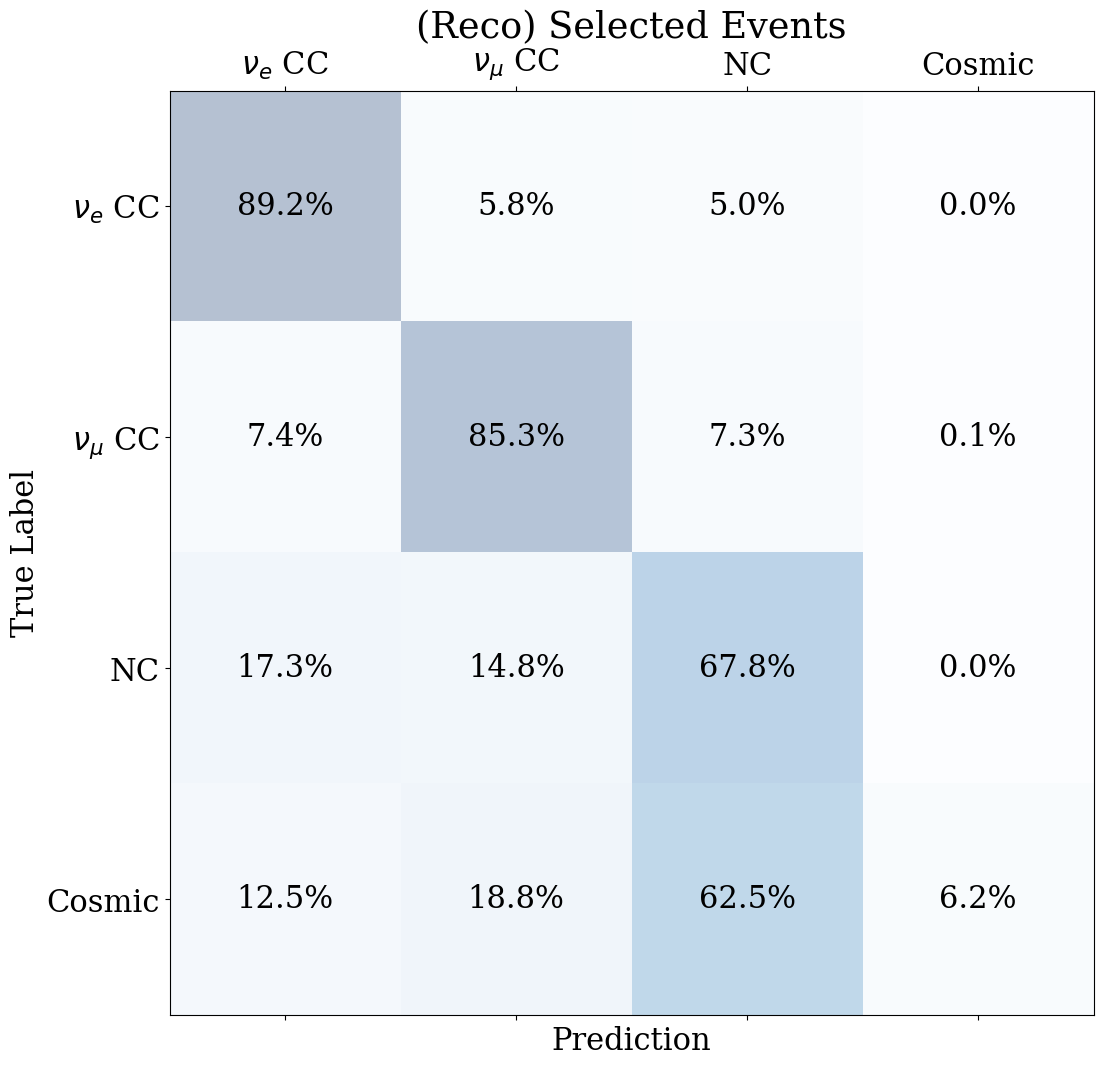

In [37]:
plot_confusion_matrix(df_selected, title="(Reco) Selected Events")

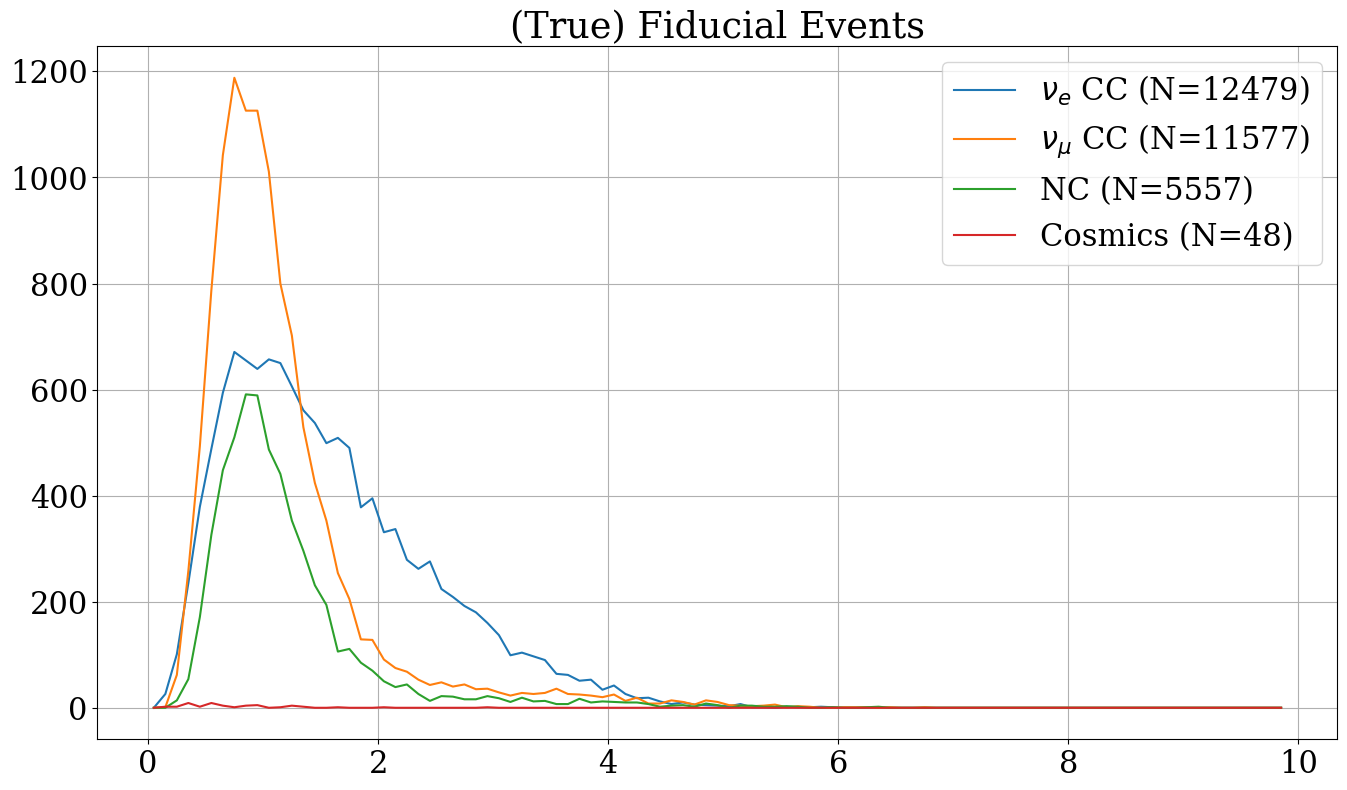

In [38]:
plot_energy(df_selected, title="(True) Fiducial Events")

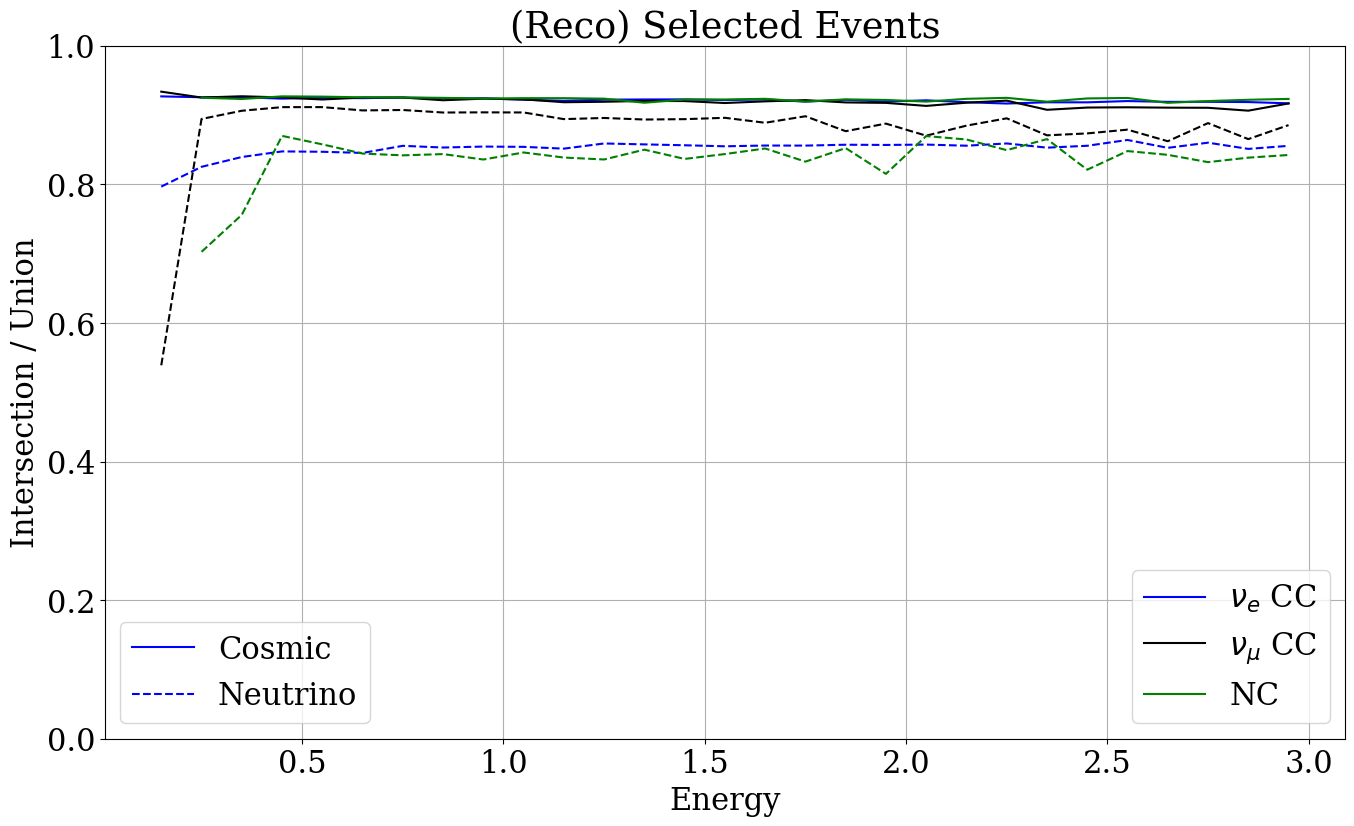

In [39]:
plot_iou(df_selected, title="(Reco) Selected Events")

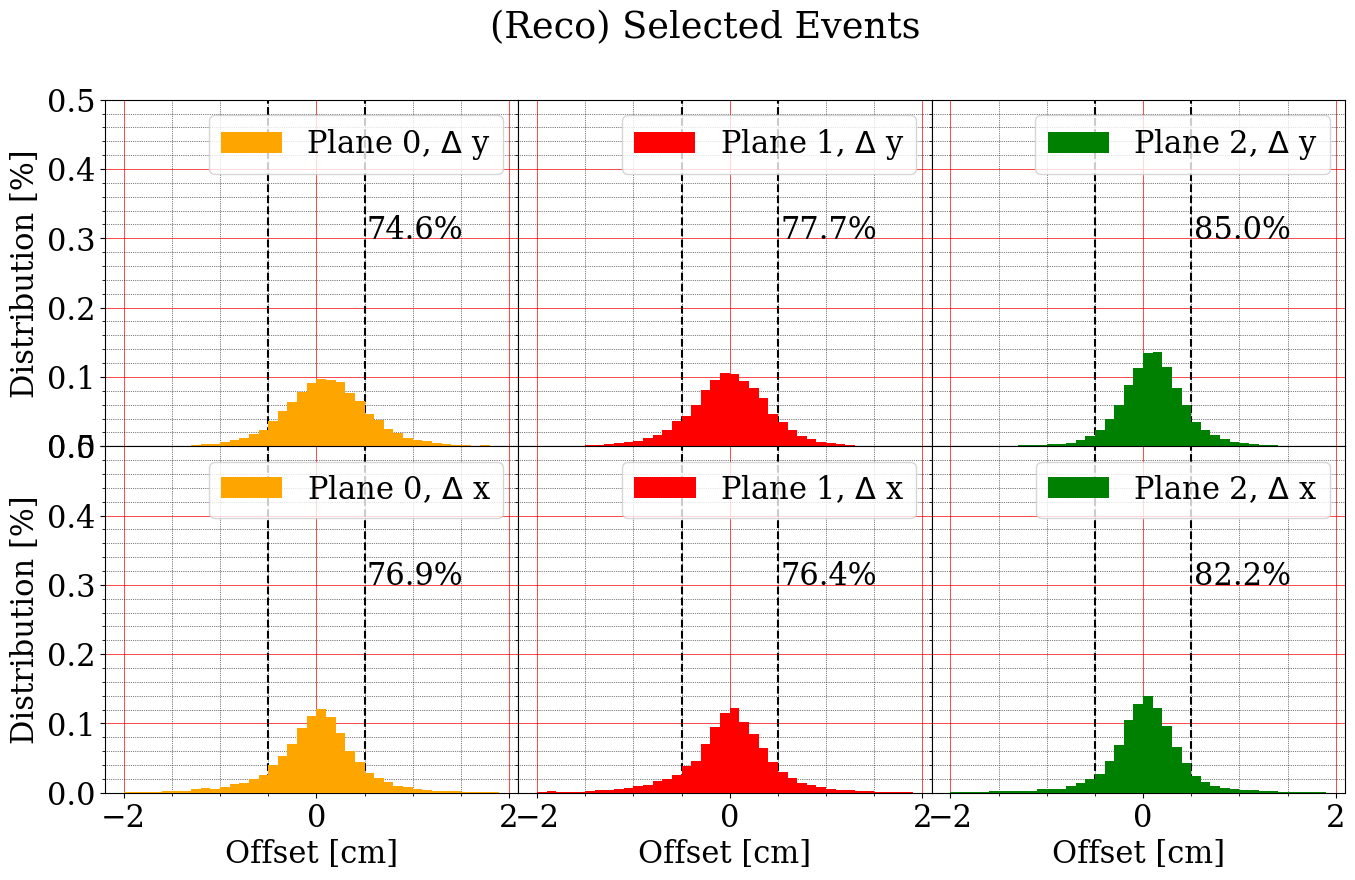

In [40]:
bins = numpy.arange(-2,2,0.1)
plot_vertex_offset_grid(df_selected.query("true_label == 0"), bins=bins, cut_line=0.5, title="(Reco) Selected Events")

In [41]:
print(numpy.mean(df_selected["vertex_res0"] < 5.0))
print(numpy.mean(df_selected["vertex_res1"] < 5.0))
print(numpy.mean(df_selected["vertex_res2"] < 5.0))

0.9701965543980311
0.9702302687030107
0.969690839823337
